In [1]:
import pandas as pd
import numpy as np

from utils.dataloader import DataLoader
from settings.constants import TRAIN_CSV

train = pd.read_csv(TRAIN_CSV, header = 0)

X_raw = train.drop("stroke", axis=1)

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = train["stroke"]

In [2]:
X.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,13,1,0,1,3,0.713046,0.711957,2
1,13,0,1,1,3,0.040347,0.260870,3
2,9,1,0,1,2,0.746745,0.286685,3
3,4,0,0,0,2,0.247576,0.187500,0
4,8,0,0,1,2,0.138999,0.205163,0


In [3]:
X.value_counts()

age  hypertension  heart_disease  ever_married  work_type  avg_glucose_level  bmi       smoking_status
0    0             0              0             3          0.041270           0.127031  0                 1
10   0             0              0             2          0.034531           0.348597  2                 1
9    1             0              1             3          0.108762           0.283604  2                 1
                                                           0.127828           0.502216  2                 1
                                                           0.197904           0.324963  3                 1
                                                                                                         ..
4    1             0              1             0          0.170760           0.957164  2                 1
                                                2          0.436525           0.514032  2                 1
5    0             0             

In [3]:
from collections import Counter

counter = Counter(y)
pos_weight = counter[0]/counter[1]
sample_weight = np.ones(len(y))
sample_weight[y == 1] *= pos_weight
counter

Counter({0: 3889, 1: 199})

In [100]:
cat_features = [0,1,2,3,4,7]
cat_features = ["age", "hypertension", "heart_disease", "ever_married", "work_type", "smoking_status"]

# Traditional ML models

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, average_precision_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
import optuna as opt

## Base estimator performance

In [10]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

base_clf = RandomForestClassifier(class_weight='balanced', 
                                  n_jobs=-1)

scores = cross_validate(base_clf, X, y, scoring='average_precision', cv=sss, verbose=1, n_jobs=-1)
fig = px.box(scores, y='test_score')
fig.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


## XGBoost

In [151]:
dmatrix = xgb.DMatrix(data=X, label=y)
xgb_params = {
    'eval_metric':'aucpr',
    'objective': 'binary:logistic', 
    'scale_pos_weight': pos_weight/100
    }

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

cv_res = xgb.cv(dtrain=dmatrix,
                params=xgb_params,
                num_boost_round=100,
                folds=sss,
                early_stopping_rounds=30,
                metrics='aucpr')

print(f'Validation precision-recall AUC {round(cv_res.loc[len(cv_res) - 1, "test-aucpr-mean"], 3)}')

Validation precision-recall AUC 0.22


In [152]:
cv_res

,train-aucpr-mean,train-aucpr-std,test-aucpr-mean,test-aucpr-std
0,0.048584,0.000000,0.048900,0.000000
1,0.100985,0.080730,0.069856,0.033206
2,0.175515,0.051705,0.131404,0.016759
3,0.211673,0.044498,0.161974,0.041538
4,0.253178,0.046576,0.180501,0.040127
5,0.290484,0.046358,0.182584,0.035531
6,0.328600,0.041509,0.198349,0.041851
7,0.360096,0.034729,0.215685,0.047541
8,0.377273,0.029875,0.216477,0.046679
9,0.391442,0.030833,0.220186,0.048087


c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


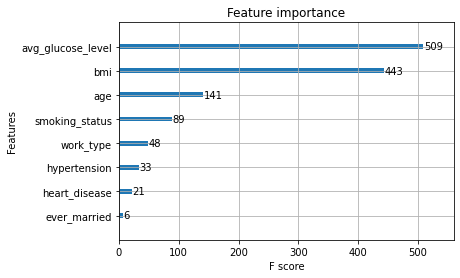

In [12]:
clf = xgb.XGBClassifier(**xgb_params)
clf.fit(X, y)
xgb.plot_importance(clf)
plt.show()

Optuna optimizations

In [131]:
import os
from dotenv import load_dotenv

load_dotenv()
XGB_DB_URL = os.getenv('XGB_DB_URL')

In [178]:
def objective(trial,data=X,target=y):
    
    clf_params ={
        'eval_metric':'MAP',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'max_depth': 3,
        'min_child_weight': 6,
        'alpha': trial.suggest_uniform('alpha', 4e-3, 0.009),
    }
    
    if clf_params["booster"] == "gbtree" or clf_params["booster"] == "dart":
        clf_params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.93, 0.95)
        clf_params['subsample'] = trial.suggest_uniform('subsample', 0.943, 0.9445)
        clf_params['scale_pos_weight'] = trial.suggest_uniform('scale_pos_weight', 1.5375, 1.5425)
        clf_params['gamma'] =  trial.suggest_uniform("gamma", 8e-3, 0.031)  
        clf_params["eta"] = trial.suggest_uniform("eta", 0.208, 0.212)
    '''
        
    if clf_params["booster"] == "dart":
        clf_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        clf_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        clf_params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        clf_params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)    
        
    '''
    
    dmatrix = xgb.DMatrix(data=data, label=target)
    
    pruning_callback = opt.integration.XGBoostPruningCallback(trial, 'test-aucpr')
    xgb_cv_res = xgb.cv(params=clf_params, dtrain=dmatrix, num_boost_round=200,
                        folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                        early_stopping_rounds=30, metrics='aucpr',
                        callbacks=[pruning_callback]
                        )
    
    aucpr = xgb_cv_res["test-aucpr-mean"].max()
    trial.set_user_attr('n_estimators', xgb_cv_res["test-aucpr-mean"].idxmax() + 1)
    
    return aucpr

xgb_study = opt.create_study(
    pruner=opt.pruners.MedianPruner(n_warmup_steps=10),
    direction='maximize',
    study_name='xgboost-reduced',
    storage=XGB_DB_URL
    )

xgb_study.optimize(objective, n_trials=400, n_jobs=-1)

[I 2021-10-24 12:23:51,352] A new study created in RDB with name: xgboost-reduced
c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2021-10-24 12:24:14,024] Trial 7 finished with value: 0.24521169999999998 and parameters: {'alpha': 0.00858619246467723, 'colsample_bytree': 0.9449259770794736, 'subsample': 0.944335610572788, 'scale_pos_weight': 1.5424917278064674, 'gamma': 0.019572427875935564, 'eta': 0.20976675551079957}. Best is trial 7 with value: 0.24521169999999998.
[I 2021-10-24 12:24:16,306] Trial 4 finished with value: 0.2476817 and parameters: {'alpha': 0.004216315256678336, 'colsample_bytree': 0.9392386398128757, 'subsample': 0.9438037271585418, 'scale_pos_weight': 1.538762502027877, 'gamma': 0.02732970872292857, 'eta': 0.2110868515551475}. Bes

In [180]:
try:
    xgb_study
except NameError:
    xgb_study = opt.load_study(study_name='xgboost-reduced', storage=XGB_DB_URL)
best = xgb_study.best_trial
print(f'Value {best.value}')
print(best.params)
print(best.user_attrs)

Value 0.25070709999999996
{'alpha': 0.005723755595176111, 'colsample_bytree': 0.9319606997944211, 'eta': 0.20895666500119897, 'gamma': 0.03002982077091499, 'scale_pos_weight': 1.537781484862568, 'subsample': 0.9442711753935601}
{'n_estimators': 10}


### Visualisations

In [181]:
opt.visualization.plot_optimization_history(xgb_study)

In [182]:
opt.visualization.plot_edf(xgb_study)

In [183]:
opt.visualization.plot_param_importances(xgb_study)

In [184]:
opt.visualization.plot_parallel_coordinate(xgb_study)

In [141]:
opt.visualization.plot_slice(xgb_study, params=['subsample'])

## LGBM

In [56]:
dset = lgb.Dataset(data=X, label=y, 
                   #categorical_feature=['age','hypertension','heart_disease','ever_married','work_type','smoking_status']
                   )
lgb_params = {
    'metric':'average_precision',
    'objective':'binary', 
    'is_unbalance': True,
    'force_col_wise':True,
    'boosting_type': 'goss'
}


lgb_cv_res = lgb.cv(params=lgb_params,
                    train_set=dset,
                    num_boost_round=50,
                    folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0),
                    metrics='average_precision',
                    callbacks=[lgb.early_stopping(30)]
                    )

lgb_cv_res_df = pd.DataFrame(lgb_cv_res)

print(f'Best validation precision-recall AUC {round(lgb_cv_res_df["average_precision-mean"].max(), 2)} at iteration {lgb_cv_res_df["average_precision-mean"].idxmax()}')
print(f'Last validation precision-recall AUC {round(lgb_cv_res_df.loc[len(lgb_cv_res_df) - 1,"average_precision-mean"], 2)} at iteration {len(lgb_cv_res_df) - 1}')

[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Inf

Model performance without specifying categories seems to be better, but there are related HP to tune using Optuna  
However the difference among optimizers is not significant

In [57]:
lgb_cv_res_df

,average_precision-mean,average_precision-stdv
0,0.145334,0.024636
1,0.167569,0.027445
2,0.174953,0.028324
3,0.179029,0.027405
4,0.182255,0.027885
5,0.187835,0.026680
6,0.191697,0.025448
7,0.193907,0.027768
8,0.193765,0.028647
9,0.195590,0.028482


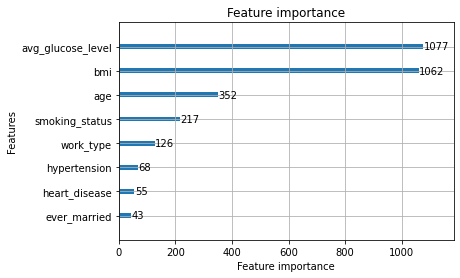

In [132]:
clf = lgb.LGBMClassifier(**lgb_params)
clf.fit(X, y)
lgb.plot_importance(clf)
plt.show()

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
LGB_DB_URL = os.getenv('LGB_DB_URL')

In [114]:
def objective(trial,data=X,target=y, boosting_type='dart'):
    
    clf_params ={
        'metric':'average_precision',
        'is_unbalance': True,
        'objective': 'binary',
        'verbose': -1,
        'max_depth': 8,
        'num_leaves': 49,
        'min_child_weight': 17,
        'min_data_in_leaf': 7,
        'force_row_wise': True,
        'max_bin': 58,
        'boosting_type': trial.suggest_categorical('booster', [boosting_type]), # trial.suggest_categorical('booster', ['gbdt', 'dart', 'goss']),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.671, 0.672),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.099, 0.101),
    
        'max_cat_threshold': 13,
        'cat_l2': trial.suggest_uniform('cat_l2', 0.0026, 0.00262),
        'min_data_per_group': 12,       
        'cat_smooth': trial.suggest_uniform('cat_smooth', 5.43, 5.44)
    }
    
    
    if clf_params["boosting_type"] in ['gbdt', 'rf', 'dart', 'goss']:
        #clf_params['max_bin'] = trial.suggest_int('max_bin', 55, 65)
        #clf_params['num_leaves'] = trial.suggest_int('num_leaves', 45, 52)
        #clf_params["max_depth"] = trial.suggest_int("max_depth", 5, 8)
        clf_params["eta"] = trial.suggest_uniform("eta", 0.07333, 0.07336)
        clf_params["min_split_gain"] = trial.suggest_uniform("min_split_gain", 0.0142, 0.0147)
        #clf_params['min_child_weight'] = trial.suggest_int('min_child_weight', 15, 19)
        #clf_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 8)        
        clf_params['feature_fraction'] = trial.suggest_uniform('feature_fraction', 0.94355, 0.94365)
        
    if clf_params['boosting_type'] in ['gbdt', 'rf', 'dart']:
        clf_params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 16)
        clf_params['bagging_fraction'] = 0.9
        clf_params['pos_bagging_fraction'] = trial.suggest_uniform('pos_bagging_fraction', 0.8, 1.0)
        clf_params['neg_bagging_fraction'] = trial.suggest_uniform('neg_bagging_fraction', 0.5, 0.7)      
                
    if clf_params["boosting_type"] == "dart":
        clf_params["uniform_drop"] = False
        clf_params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-2, 1e-1)
        clf_params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-1, 1.0)    
        clf_params["max_drop"] = trial.suggest_int("max_drop", 30, 60)  
        
        
    if clf_params['boosting_type'] == 'goss':
        clf_params['top_rate'] = round(trial.suggest_uniform('top_rate', 0.4, 0.425), 5)
        clf_params['other_rate'] =  round(trial.suggest_uniform('other_rate', 0, 1 - clf_params['top_rate']), 5)
        
    
    
    dmatrix = lgb.Dataset(data=data, label=target, categorical_feature=cat_features)
    
    pruning_callback = opt.integration.LightGBMPruningCallback(trial, 'average_precision')
    
    #try:
    lgb_cv_res = lgb.cv(params=clf_params, train_set=dmatrix, num_boost_round=50 if clf_params['boosting_type'] == 'dart' else 100,
                        folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                        metrics='average_precision',
                        callbacks=[pruning_callback, lgb.log_evaluation(period=0)] if clf_params['boosting_type'] == 'dart' else
                        [lgb.log_evaluation(period=0), pruning_callback, lgb.early_stopping(30, verbose=False)])
    
    #except lgb.basic.LightGBMError:
    #    print('-!'*50+f'\n{clf_params["boosting_type"]} params are: top rate={clf_params.get("top_rate")}, other rate={clf_params.get("other_rate")}\n'+'-!'*50)
        
    df = pd.DataFrame(lgb_cv_res)
    
    aucpr = df["average_precision-mean"].max()
    trial.set_user_attr('n_estimators', df["average_precision-mean"].idxmax() + 1)
    
    return aucpr

def create_study(name):
    return opt.create_study(
        pruner=opt.pruners.MedianPruner(n_warmup_steps=10),
        direction='maximize',
        study_name=name,
        storage=LGB_DB_URL)
    
boosters = ['goss']
postfix = '-cat-reduced'
    
lgb_study = {booster: create_study(name=booster+postfix) for booster in boosters}


[I 2021-10-23 20:39:51,030] A new study created in RDB with name: goss-cat-reduced


In [115]:
for booster, study in lgb_study.items():
    study.optimize(lambda t: objective(t, boosting_type=booster), n_trials=500, n_jobs=-1)

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\

In [116]:
try:
    lgb_study
except NameError:
    lgb_study = {booster+postfix: opt.load_study(study_name=booster+postfix, storage=LGB_DB_URL) for booster in boosters}
    
for study in lgb_study.values():
    best = study.best_trial
    print(f'Value {best.value}')
    print(best.params)
    print(best.user_attrs)

Value 0.27227669807726695
{'booster': 'goss', 'cat_l2': 0.0026121374114489826, 'cat_smooth': 5.439553645110735, 'eta': 0.07334685874148977, 'feature_fraction': 0.943555798678272, 'lambda_l1': 0.1001973060485256, 'lambda_l2': 0.6719531251493192, 'min_split_gain': 0.01426296973737735, 'other_rate': 0.05367324166933247, 'top_rate': 0.41721307786062617}
{'n_estimators': 17}


In [117]:
opt.visualization.plot_optimization_history(lgb_study.get(boosters[0]))

In [118]:
opt.visualization.plot_edf(list(lgb_study.values()))

In [11]:
opt.visualization.plot_edf(list(lgb_study.values()))

In [12]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[0]))

In [17]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[0]))

In [18]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[1]))

In [19]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[1]))

In [119]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[0]))

In [142]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[0]))

In [121]:
opt.visualization.plot_slice(lgb_study.get(boosters[0]), params=['lambda_l2'])

## FLAML experiments

In [280]:
sample_weight = np.ones(len(y))
sample_weight[y == 1] *= counter[0]/counter[1]

from flaml.model import XGBoostSklearnEstimator, LGBMEstimator

class CostSensitiveXGB(XGBoostSklearnEstimator):
    def __init__(self, **params):
        super().__init__(booster='dart', scale_pos_weight=counter[0]/(counter[1]), **params)
        
class CostSensitiveLGBM(LGBMEstimator):
    def __init__(self, **params):
        super().__init__(boosting_type='dart', scale_pos_weight=counter[0]/(counter[1]), **params)

from flaml import AutoML
automl = AutoML()
automl.add_learner(learner_name='CostXGB', learner_class=CostSensitiveXGB)
automl.add_learner(learner_name='CostLGBM', learner_class=CostSensitiveLGBM)

automl_params = {
    "time_budget": 60*30,
    "metric": 'ap',
    "eval_method":'cv',
    "estimator_list": ['lgbm', 'catboost'],
    "task": 'classification',
    "log_file_name": 'stroke_classification.log',
    "seed": 7,
    "n_jobs": 8,
    "split_ratio": 0.3,
    "n_splits": 10,
    "split_type": 'stratified',
    "sample_weight": sample_weight
}

In [281]:
automl.fit(X_train=X, y_train=y, **automl_params)

[flaml.automl: 10-24 16:54:53] {1459} INFO - Data split method: stratified
Data split method: stratified
[flaml.automl: 10-24 16:54:53] {1463} INFO - Evaluation method: cv
Evaluation method: cv
[flaml.automl: 10-24 16:54:53] {1511} INFO - Minimizing error metric: 1-ap
Minimizing error metric: 1-ap
[flaml.automl: 10-24 16:54:53] {1548} INFO - List of ML learners in AutoML Run: ['lgbm', 'catboost']
List of ML learners in AutoML Run: ['lgbm', 'catboost']
[flaml.automl: 10-24 16:54:53] {1778} INFO - iteration 0, current learner lgbm
iteration 0, current learner lgbm
[flaml.automl: 10-24 16:54:53] {1895} INFO - Estimated sufficient time budget=6590s. Estimated necessary time budget=11s.
Estimated sufficient time budget=6590s. Estimated necessary time budget=11s.
[flaml.automl: 10-24 16:54:53] {1967} INFO -  at 0.7s,	estimator lgbm's best error=0.2199,	best estimator lgbm's best error=0.2199
 at 0.7s,	estimator lgbm's best error=0.2199,	best estimator lgbm's best error=0.2199
[flaml.automl: 

In [284]:
print('Best hyperparmeter config:', automl.best_config)
print('Best ROC_PR on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 37, 'num_leaves': 64, 'min_child_samples': 6, 'learning_rate': 0.0940583942484028, 'log_max_bin': 10, 'colsample_bytree': 0.8840228967095413, 'reg_alpha': 0.07235139344173061, 'reg_lambda': 39.07035108502493}
Best ROC_PR on validation data: 0.8242
Training duration of best run: 36.24 s


In [285]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.8840228967095413,
               learning_rate=0.0940583942484028, max_bin=1023,
               min_child_samples=6, n_estimators=37, n_jobs=8, num_leaves=64,
               reg_alpha=0.07235139344173061, reg_lambda=39.07035108502493,
               verbose=-1)

## Models comparison

In [103]:
xgb_params = {
    'eval_metric':'aucpr',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'use_label_encoder': False,
    'max_depth': 3,
    'min_child_weight': 6,
    'alpha': 0.007,
    'colsample_bytree': 0.94,
    'eta': 0.211,
    'gamma': 0.028,
    'scale_pos_weight': 1.54,
    'subsample': 0.9442
}

lgbm_params = {
    'metric':'average_precision',
    'is_unbalance': True,
    'objective': 'binary',
    'boosting_type': 'goss',
    'verbose': -1,
    'learning_rate': 0.1,
    'max_depth': 8,
    'num_leaves': 49,
    'min_child_weight': 17,
    'min_data_in_leaf': 7,
    'force_row_wise': True,
    'max_bin': 58,
    'feature_fraction': 0.94,
    'lambda_l1': 0.1,
    'lambda_l2': 0.67,
    'min_split_gain': 0.014,
    'other_rate': 0.05,
    'top_rate': 0.42,
    
    'cat_l2': 0.003,
    'cat_smooth': 5.44,
    'max_cat_threshold': 13,
    'min_data_per_group': 12,
    'n_estimators':17
}

trad_classifiers = [
    SVC(class_weight='balanced', C=.005, probability=False),
    GaussianNB(priors=[counter[1]/X.shape[0], counter[0]/X.shape[0]]),
    RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=5, min_samples_split=4, min_samples_leaf=6, max_features='sqrt', n_estimators=50, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=50, learning_rate=0.001, max_depth=5, min_samples_split=4, min_samples_leaf=6, loss='exponential', max_features='log2'),
    LogisticRegression(class_weight='balanced', solver='liblinear', C=1, n_jobs=-1),
    xgb.XGBClassifier(**xgb_params, n_estimators=10),
    lgb.LGBMClassifier(**lgbm_params, n_jobs=-1)
]

In [104]:
clf = lgb.LGBMClassifier(**lgbm_params, n_jobs=-1)
clf.fit(X,y,categorical_feature=cat_features)

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] feature_fraction is set=0.94, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.67, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.67


LGBMClassifier(boosting_type='goss', cat_l2=0.003, cat_smooth=5.44,
               feature_fraction=0.94, force_row_wise=True, is_unbalance=True,
               lambda_l1=0.1, lambda_l2=0.67, max_bin=58, max_cat_threshold=13,
               max_depth=8, metric='average_precision', min_child_weight=17,
               min_data_in_leaf=7, min_data_per_group=12, min_split_gain=0.014,
               n_estimators=17, num_leaves=49, objective='binary',
               other_rate=0.05, top_rate=0.42, verbose=-1)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


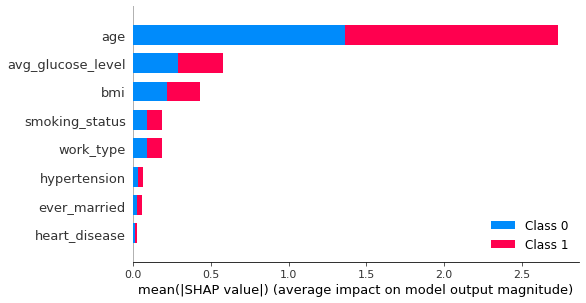

In [105]:
import shap
shap.initjs()
shap_values = shap.TreeExplainer(clf.booster_).shap_values(X)
shap.summary_plot(shap_values, X)

In [44]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(
    C=[0.0001, 0.001, 0.01, 0.1, 1, 2],
    solver=['liblinear','lbfgs','newton-cg']
)
rand_search = RandomizedSearchCV(estimator=trad_classifiers[-3], 
                                 param_distributions=param_grid, 
                                 scoring='average_precision', 
                                 n_iter=150, 
                                 n_jobs=-1, 
                                 cv=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                                 verbose=1)

search_result = rand_search.fit(X,y)
print(f'Best model {search_result.best_params_} with PR_AUC of {search_result.best_score_}')
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=150. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best model {'solver': 'liblinear', 'C': 1} with PR_AUC of 0.19474739353477238
0.1527613398797993 (0.012034415114317345) with: {'solver': 'liblinear', 'C': 0.0001}
0.1803576412833565 (0.025411647014812164) with: {'solver': 'lbfgs', 'C': 0.0001}
0.1803560377365096 (0.025412851064004767) with: {'solver': 'newton-cg', 'C': 0.0001}
0.13392426363930948 (0.01018437562390837) with: {'solver': 'liblinear', 'C': 0.001}
0.1817511656196309 (0.03325238327735614) with: {'solver': 'lbfgs', 'C': 0.001}
0.18172908308057117 (0.033248043244411586) with: {'solver': 'newton-cg', 'C': 0.001}
0.15127030647472495 (0.010346182874202428) with: {'solver': 'liblinear', 'C': 0.01}
0.1848380799788058 (0.030318435159311916) with: {'solver': 'lbfgs', 'C': 0.01}
0.18484636443285854 (0.030328430660858646) with: {'solver': 'newton-cg', 'C': 0.01}
0.18728004292749664 (0.02364353342934525) with: {'solver': 'liblinear', 'C': 0.1}
0.19147794762906906 (0.03246558

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


In [65]:
log_cols = ["Classifier", "PR_AUC", "Recall (TPR)", 'Precision', "F2"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scoring = {
    'PR_AUC': 'average_precision',
    'recall': 'recall',
    'precision': 'precision',
    'F2': make_scorer(fbeta_score, beta=2)
}
acc_dict = {}

for clf in trad_classifiers:
    name = clf.__class__.__name__
    scores = cross_validate(clf, X, y, scoring=scoring, cv=sss, verbose=1, n_jobs=-1)
    roc_auc = scores['test_PR_AUC'].mean()
    recall = scores['test_recall'].mean()
    precision = scores['test_precision'].mean()
    fbeta = scores['test_F2'].mean()
    
    acc_dict[name] = np.array([roc_auc, recall, precision, fbeta])

for clf in acc_dict:
    log_entry = pd.DataFrame([[clf, acc_dict[clf][0], acc_dict[clf][1], acc_dict[clf][2], acc_dict[clf][3]]], columns = log_cols)
    log = log.append(log_entry)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

,Classifier,PR_AUC,Recall (TPR),Precision,F2
0,SVC,0.189856,0.878333,0.109978,0.366297
0,GaussianNB,0.164512,0.925000,0.091042,0.326389
0,RandomForestClassifier,0.209344,0.748333,0.135250,0.391479
0,GradientBoostingClassifier,0.226830,0.000000,0.000000,0.000000
0,LogisticRegression,0.199036,0.791667,0.126376,0.385406
0,XGBClassifier,0.235972,0.046667,0.419618,0.056572
0,LGBMClassifier,0.234746,0.586667,0.165791,0.388726


<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='model performance', ylabel='Classifier'>

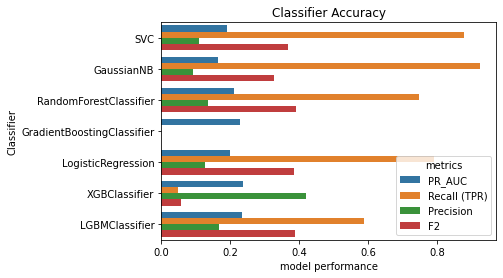

In [63]:
display(log)

plt.title('Classifier Accuracy')
log = pd.melt(log, id_vars='Classifier', var_name='metrics', value_name='model performance')
sns.set_color_codes("muted")
sns.barplot(x = 'model performance', y = 'Classifier', data = log, hue='metrics')

# Deep learning model

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
import optuna as opt

from keras.wrappers.scikit_learn import KerasClassifier

def create_model(learn_rate=0.0001, epsilon=1e-7, drop_rate=0.3, weight_constraint=2, nodes=140, init_mode='lecun_uniform', act_func='sigmoid'):
    model = Sequential()
    model.add(Dense(units=nodes, input_dim=X.shape[1], activation=act_func, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint))),
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model._name = '60-1'
    model.compile(loss='binary_logloss', optimizer=Adam(learning_rate=learn_rate, epsilon=epsilon), metrics=[AUC(curve='PR')], weighted_metrics=[AUC(curve='PR')])
    return model

In [6]:
numeric_features = ['avg_glucose_level', 'bmi']
categ_features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'smoking_status']

class_weights = {
    0: (1/counter[0]) * (X.shape[0]/2.0),
    1: (1/counter[1]) * (X.shape[0]/2.0)
    }

bias_init = tf.keras.initializers.Constant(np.log([counter[1]/counter[0]]))

In [20]:
def make_feature_cols():
    feature_columns = []
    feature_layer_inputs = {}
    
    for col in numeric_features:
        feature_columns.append(tf.feature_column.numeric_column(col))
        feature_layer_inputs[col] = tf.keras.layers.Input(shape=(1,), name=col)

    for col in categ_features:
        categ_col = tf.feature_column.categorical_column_with_vocabulary_list(key=col, vocabulary_list=X[col].unique())
        feature_columns.append(categ_col)
        feature_layer_inputs[col] = tf.keras.Input(shape=(1,), name=col, dtype=tf.int8)
        
    len_num_f = len(numeric_features)

    age_work_feature = tf.feature_column.crossed_column(
        [feature_columns[len_num_f+0], feature_columns[len_num_f+4]], hash_bucket_size=100
    )

    feature_columns.append(tf.feature_column.indicator_column(age_work_feature))

    heart_troubles_feature = tf.feature_column.crossed_column(
        [feature_columns[len_num_f+1], feature_columns[len_num_f+2]], hash_bucket_size=100
    )

    feature_columns.append(tf.feature_column.indicator_column(heart_troubles_feature))

    for col_ind, col_name in enumerate(feature_columns):
        if len(numeric_features) <= col_ind < len(numeric_features)+len(categ_features):
            feature_columns[col_ind] = tf.feature_column.indicator_column(feature_columns[col_ind])
            
    return feature_columns, feature_layer_inputs

In [77]:
def make_dataset(data, target=None):
    if target is None:
        ds = tf.data.Dataset.from_tensor_slices((dict(data)))
        return ds.batch(32)
    else:
        sample_weight = np.ones(shape=(len(target),))
        sample_weight[target == 0] = class_weights[0]
        sample_weight[target == 1] = class_weights[1]
        ds = tf.data.Dataset.from_tensor_slices((dict(data), target, sample_weight))
        return ds.batch(32)
        

In [91]:
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def make_model(in_layer, dense_feature_cols):
    x = tf.keras.layers.DenseFeatures(dense_feature_cols)(in_layer)
    x = Dense(units=128, activation='relu', kernel_initializer='glorot_normal')(x)
    drop = Dropout(rate=0.1)(x)
    x = Dense(units=256, activation='relu', kernel_initializer='glorot_normal')(drop)
    drop = Dropout(rate=0.1)(x)
    stroke_pred = Dense(units=1, activation='sigmoid', 
                        bias_initializer=bias_init)(drop)

    model = tf.keras.Model(inputs=in_layer.values(),
                           outputs=stroke_pred,
                           name='MLP-128-256-1')
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=Adam(learning_rate=3e-3,
                                 epsilon=2e-5), 
                  metrics=[AUC(name='prc', curve='PR')], 
                  weighted_metrics=[AUC(name='prc', curve='PR')])

    return model

In [92]:
def eval_model(data=X, target=y):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3)
    prauc_folds = []
    for train, valid in sss.split(data, target):
        train_ds = make_dataset(data=data.iloc[train], target=target.iloc[train])
        valid_ds = make_dataset(data=data.iloc[valid], target=target.iloc[valid])
    
        feature_cols, feature_layer_in = make_feature_cols() 
        model = make_model(feature_layer_in, feature_cols)
        history = model.fit(train_ds,
              validation_data=valid_ds,
              class_weight=class_weights,
              epochs=300,
              shuffle=True,
              verbose=1,
              callbacks=tf.keras.callbacks.EarlyStopping(patience=20, 
                                             monitor='val_prc',
                                             mode='max',
                                             min_delta=1e-4,
                                             restore_best_weights=True))

        scores = model.evaluate(valid_ds, verbose=0)

        prauc_folds.append(scores[1])
      
    return np.mean(prauc_folds)

eval_model()


Epoch 1/300
90/90 [==============================] - 4s 14ms/step - loss: 1.7761 - prc: 0.0956 - weighted_prc: 0.9754 - val_loss: 1.8119 - val_prc: 0.1184 - val_weighted_prc: 0.7230
Epoch 2/300
90/90 [==============================] - 0s 5ms/step - loss: 1.2466 - prc: 0.1086 - weighted_prc: 0.9786 - val_loss: 1.3154 - val_prc: 0.1539 - val_weighted_prc: 0.7748
Epoch 3/300
90/90 [==============================] - 0s 5ms/step - loss: 1.0074 - prc: 0.1164 - weighted_prc: 0.9801 - val_loss: 0.9911 - val_prc: 0.1975 - val_weighted_prc: 0.8123
Epoch 4/300
90/90 [==============================] - 0s 5ms/step - loss: 0.9597 - prc: 0.1199 - weighted_prc: 0.9806 - val_loss: 1.0716 - val_prc: 0.1958 - val_weighted_prc: 0.8087
Epoch 5/300
90/90 [==============================] - 0s 5ms/step - loss: 0.8923 - prc: 0.1288 - weighted_prc: 0.9817 - val_loss: 0.9131 - val_prc: 0.2008 - val_weighted_prc: 0.8105
Epoch 6/300
90/90 [==============================] - 0s 5ms/step - loss: 0.8458 - prc: 0.1372 

0.19643596932291985

In [10]:
import os
from dotenv import load_dotenv

load_dotenv()  
DL_DB_URL = os.getenv('DL_DB_URL')

In [99]:
def objective(trial,data=X,target=y):      

    X_train, X_val, y_train, y_val = train_test_split(data,target,test_size=0.3,stratify=target)
    
    train_ds = make_dataset(data=X_train, target=y_train)
    valid_ds = make_dataset(data=X_val, target=y_val)
    
    feature_cols, feature_layer_in = make_feature_cols()

    x = tf.keras.layers.DenseFeatures(feature_cols)(feature_layer_in)
    x = Dense(units=trial.suggest_categorical('units_l1', [64, 128, 256]), 
              activation='relu', 
              kernel_initializer='glorot_normal', name='1')(x)
    drop = Dropout(rate=trial.suggest_categorical('drop', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    x = Dense(units=trial.suggest_categorical('units_l2', [64, 128, 256, 512]), 
              activation='relu',
              kernel_initializer='glorot_normal', name='2')(drop)
    drop = Dropout(rate=trial.suggest_categorical('drop', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    #x = Dense(units=trial.suggest_categorical('units_l3', [32, 64, 128, 256]), activation='relu', name='3')(x)
    stroke_pred = Dense(units=1, activation='sigmoid', 
                        bias_initializer=bias_init)(drop)

    model = tf.keras.Model(inputs=feature_layer_in.values(),
                       outputs=stroke_pred)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2),
                             epsilon=trial.suggest_loguniform('eps', 1e-6, 1e-4)), 
              metrics=[AUC(name='prc', curve='PR')])
    
    c_backs = [tf.keras.callbacks.EarlyStopping(patience=10, 
                                             monitor='val_prc',
                                             min_delta=1e-4,
                                             mode='max',
                                             restore_best_weights=True),
            opt.integration.TFKerasPruningCallback(trial, 'val_prc')]

    history = model.fit(train_ds,
              validation_data=valid_ds,
              class_weight=class_weights,
              shuffle=True,
              verbose=0,
          epochs=100,
          callbacks=[c_backs]
          )
    
    trial.set_user_attr('n_epochs', len(history.history["val_prc"]))

    scores = model.evaluate(valid_ds, verbose=0)

    return scores[1]

dl_study = opt.create_study(
    pruner=opt.pruners.MedianPruner(n_warmup_steps=10),
    direction='maximize',
    study_name='keras-2l-drop',
    storage=DL_DB_URL
    )

dl_study.optimize(objective, n_trials=400, n_jobs=-1)

[I 2021-10-29 18:55:04,790] A new study created in RDB with name: keras-2l-drop
c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2021-10-29 18:55:31,702] Trial 0 finished with value: 0.1906726360321045 and parameters: {'units_l1': 64, 'drop': 0.5, 'units_l2': 64, 'lr': 0.001469061417764997, 'eps': 7.5317719656928055e-06}. Best is trial 0 with value: 0.1906726360321045.
[I 2021-10-29 18:55:34,009] Trial 5 finished with value: 0.18142260611057281 and parameters: {'units_l1': 64, 'drop': 0.0, 'units_l2': 64, 'lr': 0.009512593396516862, 'eps': 5.480682014261626e-06}. Best is trial 0 with value: 0.1906726360321045.
[I 2021-10-29 18:55:35,919] Trial 3 finished with value: 0.24059663712978363 and parameters: {'units_l1': 256, 'drop': 0.8, 'units_l2': 64, 'lr

In [12]:
best = dl_study.best_trial
print(f'Value {best.value}')
print(best.params)
print(best.user_attrs)

Value 0.29721903800964355
{'epochs': 300, 'eps': 7.2411861231906036e-06, 'init': 'glorot_normal', 'lr': 0.0016633801060945605, 'units_l1': 128, 'units_l2': 256}
{'n_epochs': 29}


In [79]:
opt.visualization.plot_optimization_history(dl_study)

In [80]:
opt.visualization.plot_parallel_coordinate(dl_study)

In [82]:
opt.visualization.plot_slice(dl_study, params=['eps'])

In [93]:
feature_cols, feature_layer_in = make_feature_cols() 
dl_model = make_model(feature_layer_in, feature_cols)

In [94]:
dl_model.__class__.__name__

'Functional'

# Model export and validation

In [95]:
import pickle
import json
import pandas as pd

from utils.dataloader import DataLoader 
from settings.constants import TRAIN_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

raw_train = pd.read_csv(TRAIN_CSV)
x_columns = specifications['description']['X']
y_column = specifications['description']['y']

X_raw = raw_train[x_columns]

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = raw_train.stroke

model = dl_model

if model.__class__.__name__ == 'Functional':
    ds = make_dataset(X,y)
    model.fit(ds,
              class_weight=class_weights,
              epochs=40,
              shuffle=True,
              verbose=0)
    
    model.save(f'models/{model.name}.h5')
    del model, dl_model

else:
    if model.__class__.__name__ == 'LGBMClassifier':
        model.fit(X, y, categorical_feature=cat_features)

    else:
        model.fit(X, y)


    with open(f'models/{model.__class__.__name__}.pickle', 'wb') as f:
        pickle.dump(model, f)

In [106]:
import pickle
import json
import pandas as pd

from utils.dataloader import DataLoader 
from settings.constants import VAL_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

x_columns = specifications['description']['X']
y_column = specifications['description']['y']

raw_val = pd.read_csv(VAL_CSV)
x_raw = raw_val[x_columns]

loader = DataLoader()
loader.fit(x_raw)
test_X = loader.load_data()
test_y = raw_val.stroke

loaded_model = pickle.load(open(f'models/LGBMClassifier.pickle', 'rb'))
dl_model = tf.keras.models.load_model(f'models/MLP-128-256-1.h5')

In [107]:
# predict probabilities
y_pred_prob = loaded_model.predict_proba(test_X)
# keep probabilities for the positive outcome only
y_pred_prob = y_pred_prob[:, 1]

In [97]:
test_ds = make_dataset(test_X)
y_pred_prob = dl_model.predict(test_ds)

Best Threshold=0.386, F2=0.404


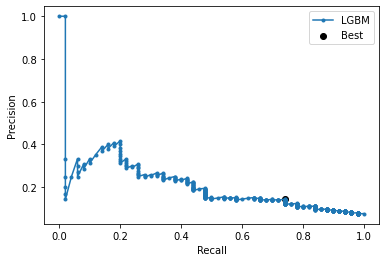

In [108]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(test_y, y_pred_prob)
# convert to f2 score
beta=2
fbeta = ((1 + beta**2)* precision * recall) / (beta**2*precision + recall + 1e-7)
# locate the index of the largest f score
ix = np.argmax(fbeta)
best_threshold = round(thresholds[ix],3)
print(f'Best Threshold={best_threshold}, F{beta}={round(fbeta[ix], 3)}')
# plot the roc curve for the model

plt.plot(recall, precision, marker='.', label='LGBM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Normalized CM
[[0.77263374 0.22736626]
 [0.26       0.74      ]]


Text(0.5, 1.0, "<class 'lightgbm.sklearn.LGBMClassifier'>")

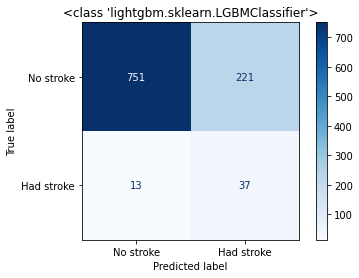

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = (loaded_model.predict_proba(test_X)[:,1] >= best_threshold).astype(bool)

print(f'Normalized CM')
print(confusion_matrix(
    test_y,
    y_pred,
    normalize='true'))
disp = ConfusionMatrixDisplay.from_predictions(
    test_y,
    y_pred,
    display_labels=['No stroke', 'Had stroke'],
    cmap=plt.cm.Blues
)

disp.ax_.set_title(f'{loaded_model.__class__}')

In [52]:
from sklearn.metrics import classification_report

target_names = ['No stroke', 'Stroke']
print(classification_report(test_y, 
                            y_pred, 
                            target_names=target_names))

              precision    recall  f1-score   support

   No stroke       0.98      0.77      0.87       972
      Stroke       0.14      0.74      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.76      0.55      1022
weighted avg       0.94      0.77      0.83      1022

